## Vital Elements of Calculus Series

# Part 4: Automatic Differentiation

In the previous post we detailed how we can derive derivative formulae for any function constructed from elementary functions and operations, and how derivatives of such functions are themselves constructed from elementary functions/operations.  These facts have far-reaching consequences for the practical computing of derivatives - allowing us to construct a very effective derivative calculator called *Automatic Differentiaton* which we detail here.

In [1]:
# imports from custom library
import sys
sys.path.append('../../')
import numpy as np
import matplotlib.pyplot as plt
from mlrefined_libraries import calculus_library as calclib
from mlrefined_libraries import basics_library as baslib

In [2]:
%load_ext autoreload
%autoreload 2

# 1.  Information flow in derivative calculations

In this Section we describe how one can quickly code up the so-called *forward* method of Automatic Differentiation, a natural and almost immediate implementation of the derivative rules discussed the previous post, and illustrated in the examples described there [[1]](#endnotes).  This is an excellent choice of derivative calculator - superior in accuracy to the Numerical Differentiation (discussed in the second post of this series), and not much more difficult to construct now that we are aware of the derivative formula / rules in Tables 1 and 2.  

## 1.1  Information flow

- At this point we have already seen how all of these things operate in a forward manner on the computation graph
    - construction of functions 
    - evaluation of function
    - computation of derivative
    
So when we build our auto-differentiator, we build it to follow this framework as well.

- Eveything to do with building / differentiationg complex functions comes in the form of our two tables: one contains elementary functions, the other elementary operations - so we should organize our code like this as well


- Because we have the same listing of elements on our two tables for evaluation of the function and the derivative, whenever we update the value of one we always update the value of the other.  This implies that we can compute both at the same time, i.e., perform the same operations on each.

## 1.2  Implications of the chain rule

# 2.  Building an AD calculator

With the points of Section 1 in mind - all we need to get started on our journey to build an AD calculator is a simple Python class - defined below - whose objects will store two values: the current evaluation value of a function, called *val*, and its derivative value, called *der*.  Note: those wanting a good introduction to Python classes, in particular for implementing mathematical functions and objects, can see e.g., [this excellent book](http://hplgit.github.io/primer.html/doc/pub/class/class-readable.html).

In [68]:
# create a class for straight input
class AD:
    def __init__(self,**kwargs):
        # we need variables for the value (val) and derivative (der) of our input function 
        self.val = 0
        self.der = 1
        
        # re-assign these default values 
        if 'val' in kwargs:
            self.val = kwargs['val']
        if 'der' in kwargs:
            self.der = kwargs['der']

## 2.2 Building up an Automatic Differentiator  by example 

We will build up our Automatic Differentator graduatlly by going through a number of examples and adding formulae / rules from Tables 1 and 2 we use one by one.  This will let us add in a few optinal ideas - including the notion of *operator overloading* - to help make our calculator easier (for humans) to use.

#### <span style="color:#a50e3e;">Example. </span> Derivative of $g(w) = w^n$

For our first example lets create a function - that takes our AutoDiff object in as input -  and updates the function / derivative values it contains according to the power function derivative formula in Table 1.  We do this in the next Python cell.

Note that in order for this function to be as flexible as possible (we want to be able to feed *functions* into this, not just points) we code in an explicit usage of the *chain rule* to the derivative update.

In [69]:
# our power calculator 
def power(g,n):
    # Calculate value
    val = g.val**n

    # Calculate derivative
    der = n*g.val**(n-1)*g.der

    # Update AutoDiff object evaluation and derivative value
    new_g = AD(val=val,der=der)
    
    # Return updated object
    return new_g

Lets try it out by printing a few function / derivative values, in particular choosing $n=3$ i.e., $g(w) = w^3$.

In [70]:
# create our function to differentiate - notice this uses our homemade sine function
g = lambda w: power(w,3)

# initialize our AutoDiff object at each point
a1 = AutoDiff(val = 0); a2 = AutoDiff(val = 0.5)

# evaluate
result1 = g(a1); result2 = g(a2)

# print results
print ('evaluation of g at ' + str(0) + ' = ' + str(result1.val))
print ('derivative of g at ' + str(0) + ' = ' + str(result1.der))

print ('evaluation of g at ' + str(0.5) + ' = ' + str(result2.val))
print ('derivative of g at ' + str(0.5) + ' = ' + str(result2.der))

evaluation of g at 0 = 0
derivative of g at 0 = 0
evaluation of g at 0.5 = 0.125
derivative of g at 0.5 = 0.75


This looks right - but lets evaluate / plot a whole range of points to visualize the derivative better and double check that the calculations are correct everywhere.  In the next Python cell we have a simple plotter that takes in a range of input values and a user-defined function - built out of AutoDiff components like our power function above - and plots the function / derivative values over the input range. 

In [92]:
# use simple plotting function to compute function/derivative values of a fine grid of points and plot the results
def simple_AD_plot(wvals,g):
    # plot
    ginits = [AD(val = u) for u in wvals]

    # collect function and gradient values to plot
    results = [g(w) for w in ginits]
    gvals = [r.val for r in results]
    dvals = [r.der for r in results]

    # create figure and plot all
    fig = plt.figure(figsize = (10,5))
    plt.plot(wvals,gvals,color = 'b')
    plt.plot(wvals,dvals,color = 'r')
    plt.legend(['original function','derivative function'],fontsize = 15, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

Lets try it out by using our simple_plotter to calculate/plot a range of derivative value - trying out in particular $g(w) = w^3$.

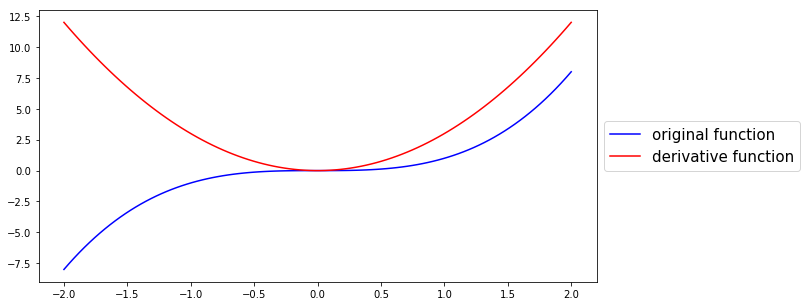

In [72]:
# use the simple plotter to calculate/visualize a derivative
g = lambda w: power(w,3)
wvals = np.linspace(-2,2,100) # points over which to calculate derivative
simple_AD_plot(wvals,g)

This looks good!  Computing the derivative directly using the power rule gives $\frac{\mathrm{d}}{\mathrm{d}w}w^3 = 3w^2$.  We can plot this below - using the raw equation for both the original function and its derivative - to check that it matches the above.  

The next Python cell contains a simple plotter that will allow us to do just that - it takes in two functions defined by their equations plots them both over a range of input points.

In [73]:
# use simple plotting function to compute function/derivative values of a fine grid of points and plot the results
def simple_eq_plot(wvals,g_true,g_der):
    # make real function / derivative values
    gvals = g_true(wvals)
    dvals = g_der(wvals)
    
    # create figure and plot all
    fig = plt.figure(figsize = (10,5))
    plt.plot(wvals,gvals,color = 'b')
    plt.plot(wvals,dvals,color = 'r')
    plt.legend(['original function','derivative function'],fontsize = 15, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

We use this plotter in the next cell.

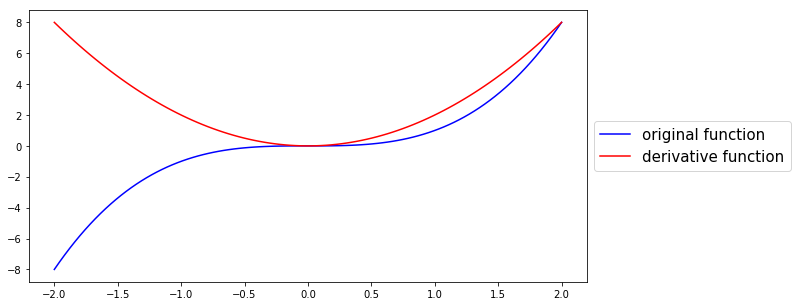

In [74]:
# create input values and function/derivative values from equations
g_true = lambda w: w**3
g_der = lambda w: 2*w**2
wvals = np.linspace(-2,2,100) # points over which to calculate derivative
simple_eq_plot(wvals,g_true,g_der)

Visually comparing the above to the result of our AD calculator we can see that we have a perfect match.  One can repeat this for any power $n$ desired and will see that the results from our AD calculator always come out perfect.

And one final note about readability.  Right now in order to use the power function we employ a direct function call via the somewhat clunky notation

```
power(g,n)
```

It would be nice - i.e., more human readable - to be able to write this in Python using more natural Pythonic notation for 'raising to the power of n'.  We use this when - for example - we can raise a floating point value g to a number n in Python which we can write in Python as

```
g**n
```

However if we try this notation with an AutoDiff object we will get an error, as Python will think we working with a floating point value.

We can actually force Python to adopt our definition ```power(g,n)``` when we use the \*\* operator on AutoDiff objects by **overloading** it (this only affects how Python treats our AutoDiff objects, you can still use \*\* as you normally would with floating point values).  Then if g is an AutoDiff object and we write ``g**n`` Python will interpret this correctly as ``power(g,n)``. 

```g**n``` $\longrightarrow$ ```power(g,n)```


We make this assignment in the following Python cell. 

In [95]:
# overload the power operator for AutoDiff objects
AD.__pow__ = power

Now we can use our power rule derivative calculator power functions much more Pythonically.  For example, we can reproduce the previous plot of the AD derivative of $w^3$, as we do in the next Python cell.

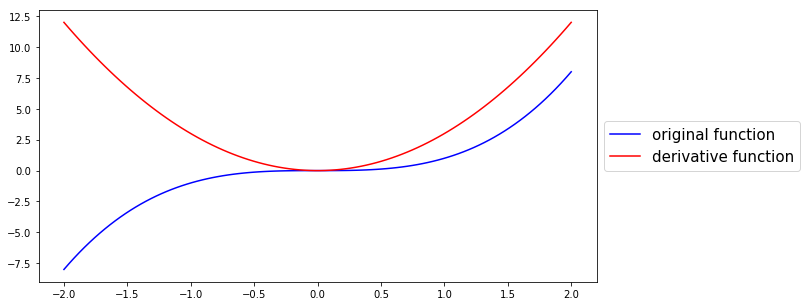

In [76]:
# use the simple plotter to calculate/visualize a derivative
g = lambda w: w**3
wvals = np.linspace(-2,2,100) # points over which to calculate derivative
simple_AD_plot(wvals,g)

#### <span style="color:#a50e3e;">Example. </span> Derivative of $g(w) = \text{sin}(w^3)$

In Section 1.4 where we first saw this example, we saw its decomposition into elementary functions and operations as

\begin{array}
\
a(w) = w^3 \\
b(a) = \text{sin}(a)\\
\end{array}

Which of the formulae / rules from Tables 1 and 2 are involved here?  We can see that there are two - both of which are from Table 1: the power rule, and rule for differentiating sine.  Since we already implemented the power rule in the previous example all we need to do is code up a sine derivative rule.  Note - as with the power rule - because we want our implementation to be of general use, we need to code up the sine rule *with an explicit application of the chain rule*.  

In the next Python cell we have our homemade sine derivative calculator that updates the input function and derivative values as given by the formal rule for sine in Table 1 and the chain rule.

In [77]:
# our homemade sine function - made general to accept a function as input (hence the explicit application of the chain rule)
def sin(g):
    # Calculate new current value
    val = np.sin(g.val)

    # Calculate new current derivative value
    der = np.cos(g.val)*g.der

    # Update AutoDiff object evaluation and derivative value
    new_g = AD(val=val,der=der)
    
    # Return updated object
    return new_g

Lets quickly test it out over a fine grid of input points to visualize its results better.  Here we use the same simple AD plotter we used in the first example to plot out the function / derivative values of $\text{sin}(w)$ over a grid of input points.

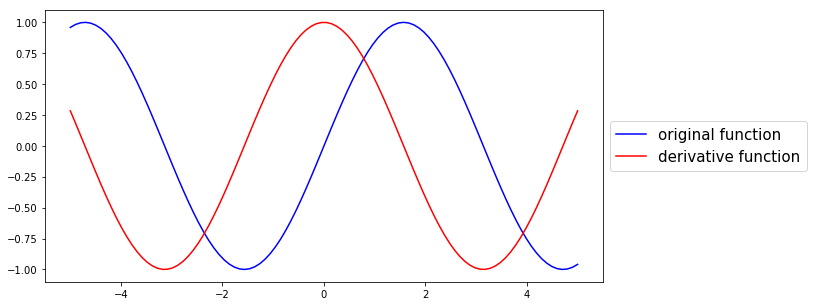

In [78]:
# use the simple plotter to calculate/visualize a derivative
g = lambda w: sin(w)
wvals = np.linspace(-5,5,100) # points over which to calculate derivative
simple_AD_plot(wvals,g)

This looks great.  Now - since we already have the power rule coded up in the first example - we can completely compute the derivative of what we are really after - $\text{sin}(w^3)$.  We do this in the next Python cell.

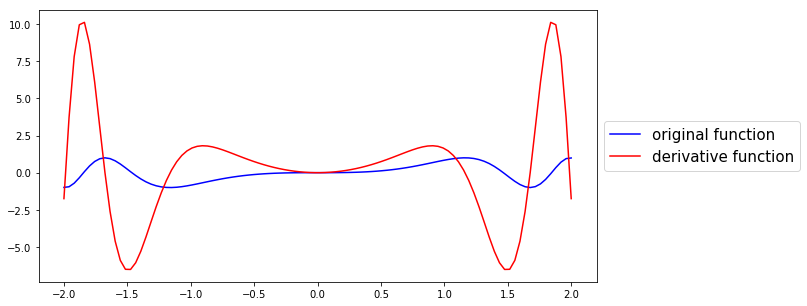

In [79]:
# use the simple plotter to calculate/visualize a derivative
g = lambda w: sin(w**3)
wvals = np.linspace(-2,2,100) # points over which to calculate derivative
simple_AD_plot(wvals,g)

Does this match up with the original function / derivative?  In the previous Section we found that the formula for the derivative was $\text{cos}(w^3) \cdot 3 \cdot w^2$.  Lets find out in the next Python cell. 

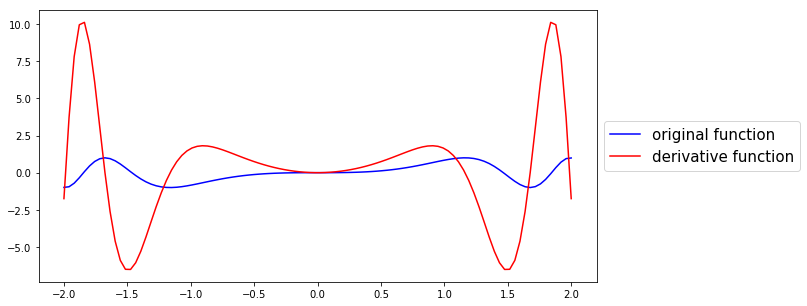

In [80]:
# create input values and function/derivative values from equations
g_true = lambda w: np.sin(w**3)
g_der = lambda w: np.cos(w**3)*3*w**2
wvals = np.linspace(-2,2,100) # points over which to calculate derivative
simple_eq_plot(wvals,g_true,g_der)

It looks like indeed our AD calculator computes the derivative perfectly for this example.

#### <span style="color:#a50e3e;">Example. </span> Derivative of  $g(w) = \text{sin}(w)\cdot\text{tanh}(w)^3 + w$

We can deconstruct this function into its elementary parts as

\begin{array}
\
a(w) = \text{sin}(w) \\
b(w) = \text{tanh}(w) \\
c(b) =  b^3 \\
d(a,c) = a\cdot c \\
f(d,w) =  d + w \\
\end{array}

we can see that the derivative formula / rules we will need to build this function include: the power, product, and summation rules, and sine / tanh formulae.  Since we have already made the power rule and sine formula in the previous examples, we do not need to remake those.  In the next Python cell we have the tanh formula - complete with chain rule.

In [98]:
# our homemade tanh function - made general to accept a function as input (hence the explicit application of the chain rule)
def tanh(g):
    # Calculate new current value
    val = np.tanh(g.val)

    # Calculate new current derivative value
    der = (1-np.tanh(g.val)**2)*g.der

    # Update AutoDiff object evaluation and derivative value
    new_g = AD(val=val,der=der)
    
    # Return updated object
    return new_g

Up next - the summation and product rules.

In [83]:
# The summation rule
def add(f,g):
    # Calculate value
    val = f.val + g.val

    # Calculate derivative
    der = f.der + g.der

    # Update AutoDiff object evaluation and derivative value
    new_g = AD(val=val,der=der)
    
    # Return updated object
    return new_g

In [84]:
# The product rule
def product(f,g):      
    # Calculate value
    val = f.val*g.val

    # Calculate derivative
    der = f.val*g.der + f.der*g.val

    # Update AutoDiff object evaluation and derivative value
    new_g = AD(val=val,der=der)
    
    # Return updated object
    return new_g

As with the power rule - as detailed in the first example - we can overload the addition '+' and multiplication '\*' Pythonic operators so that Python understands how these standard operators apply to our AutoDiff objects.

```f*g``` $\longrightarrow$ ```product(f,g)```

```f+g``` $\longrightarrow$ ```add(f,g)```

We make these assignments in the next Python cell.

In [94]:
# overload the addition operator for our AutoDiff objects
AD.__add__ = add

# overload the product operator for our AutoDiff objects
AD.__mul__ = product

Finally, with cosine and the summation / product rules defined we can compute the derivative of 

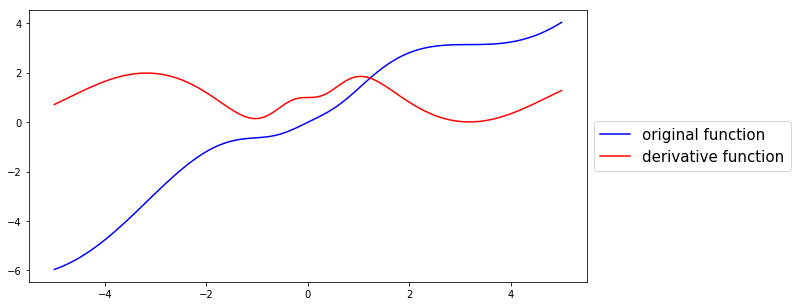

In [97]:
# use the simple plotter to calculate/visualize a derivative
g = lambda w: sin(w)*tanh(w)**3 + w
wvals = np.linspace(-5,5,100) # points over which to calculate derivative
simple_AD_plot(wvals,g)

### Summary and further steps

To further develop this AD calculator we can continue to code up formulae / rules from Tables 1 and 2 in a completely similar manner to what we have seen with the examples here. 

## 2.3  The only difference between theory and practice

The only difference between theory and practice is this: the computation graph of a function is more effecient than the function itself to a computer.  Take an example like 

$$
g(w) = \frac{\text{sin}(w^2)}{w^2}
$$

versus its computation graph which we can list as the sequence of the following two equations

\begin{array}
\
a = w^2 \\
b = \text{sin}(a) \\
c = \frac{b}{a} \\
\end{array}

Although both represent the same relationship, evaluating the full function (and its derivative) is more costly than evaluating the computation graph because $w^2$ is constructed twice in the full version.

<a id='endnotes'></a>
## Endnotes

[1]  We build on the ideas presented here in a future post where we discuss the *reverse* method of automatic differentiation, also known as the *backpropagation algorithm*, that presents a clever twist on the forward method in order to more effeciently deal with derivatives of multi-variable functions (note: so far we have dealt only with single variable functions). 

[2]  The first approach one might take to execute on this vision is to try to automate the exact experience of hand calculating derivatives *algebraically*.  In other words, to deal with mathematical equations precisely as we do with pencil and paper, using a [computer algebra system](https://en.wikipedia.org/wiki/Computer_algebra_system).  Such a derivative calculator - that deals with derivatives using symbolic computation (i.e., algebra on the computer) - is called a *Symbolic Differentiator*.  However there are a few reasons why - at least for machine learning / deep learning applications - why *Automatic Differentiation* is a better choice.  

First off, the Automatic Differentiator employs the same central thrust as Symbolic Differentiation: we directly code up the deriative rules and employ them automatically, only using natural programming structures and practices.   So there is no need to invest time in learning about computer algebra systems.

Secondly expressing derivative equations algebraically can be quite unweildly.  For example, the rather complicated looking function


\begin{equation}
g(w) = \text{sin}\left(e^{\,5\text{tanh}^2(w) + w^5}\right)\text{log}\left(\frac{1}{w^2 + 1} \right)\frac{w^2 + 1}{\text{cos}(\text{sin}(w))}
\end{equation}

has an expansive algebraic derivative.   Below are just the first few terms 

$$
\frac{\mathrm{d}}{\mathrm{d}w}g(w) = -2w\,\text{sin}\left(e^{\,5\text{tanh}^2(w) + w^5}\right) \, \frac{1}{\text{cos}(\text{sin}(w))} + 2w\,\text{log}\left(\frac{1}{w^2 + 1}\right)\text{sin}\left(e^{\,5\text{tanh}^2(w) + w^5}\right)\frac{1}{\text{cos}(\text{sin}(w))} + \cdots
$$

And this sort of problem is exponentially worse - to the point of being a considerable computational burden - when dealing with multivariable functions.  Such an example illustrates the real need to automatic *simplifying* of algebraic expressions as well, ideally during the differentiation process to make sure things do not get too far out of hand. 

Automatic Differentiation  - while not algebraic method - essentially does this simpfliciation automatically while computing derivatives.  With it we can ditch the idea of symbolic computation and use standard programming tools to code up and deploy the derivative rules in order to create a robust and accurate derivative calculator.

<blockquote style="border-left: 5px solid; border-left-color: #ccc; background: white;"><p>The content of this notebook is supplementary material for the textbook Machine Learning Refined (Cambridge University Press, 2016). Visit <a href="http://mlrefined.com">http://mlrefined.com</a> for free chapter downloads and tutorials, and <a href="https://www.amazon.com/Machine-Learning-Refined-Foundations-Applications/dp/1107123526/ref=sr_1_1?ie=UTF8&amp;qid=1474491657&amp;sr=8-1&amp;keywords=machine+learning+refined">our Amazon site</a> for details regarding a hard copy of the text.</p>
</blockquote>